In [1]:
from utils_csa import show_model_accuracy, save_obj, load_obj

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pytz import timezone
from datetime import datetime, timedelta, date

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score


# Lib to calcul financial indicators https://github.com/mrjbq7/ta-lib
import talib

# Lib to import ipynb : https://pypi.org/project/import-ipynb/
import import_ipynb
import algocryptos_preprocessing as alg_preproc
import algocryptos_gridsearch as alg_gridsearch

from pprint import pprint

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

#np.set_printoptions(threshold='nan')

importing Jupyter notebook from algocryptos_preprocessing.ipynb
importing Jupyter notebook from algocryptos_gridsearch.ipynb


In [2]:
# ------------------ PARAMETERS ------------------ #
# ['y_+3h_value', 'y_+3h_classif',, 'y_+6h_value', 'y_+6h_classif', 'y_+12h_value', 'y_+12h_classif','y_+1d_value', 'y_+1d_classif', 'y_+2d_value', 'y_+2d_classif', 'y_+3d_value', 'y_+3d_classif', 'y_+7d_value', 'y_+7d_classif', 'y_+15d_value', 'y_+15d_classif', 'y_+30d_value', 'y_+30d_classif']
id_cryptocompare = "7605" # ether 7605
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
threshold = 0.5
dict_hours_labels  = {3:'3h', 6:'6h', 12:'12h', 24:'1d', 24*2:'2d', 24*3:'3d', 24*7:'7d', 24*15:'15d', 24*30:'30d'}

In [3]:
# ------------------ LOAD DATA FROM DATABASE ------------------ #

# ONE CRYPTO
#df = alg_preproc.get_global_dataset_for_crypto("236131")
#df2 = df.reset_index(drop=True)

# TOP N CRYPTOS
#dict_df = alg_preproc.get_global_datasets_for_top_n_cryptos(10)

# ------------------ LOAD DATA FROM FILE ------------------ #
# save_obj(dict_df, 'dict_df_2018_10_31')
# dict_df = load_obj('dict_df_2018_10_26')
dict_df = load_obj('dict_df_2018_10_31')
dict_df.keys()

dict_keys(['1182', '5031', '7605', '202330', '166503', '4614', '3808', '171986', '321992', '5038'])

In [4]:
# ------------------ PRE-PROCESSING : Calcul y + split data ------------------ #
columns_nb = 0
df_new_dict = {}
df_new_list = []

def calcul_values_of_y(df, dict_hours_labels, increase_target_pct):
    increase_target_pct = increase_target_pct / 100
    
    for key in dict_hours_labels:
        label_value = 'y_+' + dict_hours_labels[key] + '_value'
        label_classif = 'y_+' + dict_hours_labels[key] + '_classif'
        # calcul several y searched (value)
        df[label_value] = df.close_price.shift(-key)
        
        # perform calcul to use binary classification
        df[label_classif] = ((df[label_value] - df['close_price']) / df['close_price']) > increase_target_pct
    
    return df

def do_split_data(df_p, columns_nb_p):
    # separe x,y
    X = df_p.iloc[:,range(1, columns_nb_p)]
    y = df_p.iloc[:,range(columns_nb_p, len(df_p.columns))]

    # split data in training / validating / testing
    return train_test_split(X, y, random_state=0, shuffle=False)

# calcul y for each crypto
for key_id_cryptocompare, df_one_crypto in dict_df.items():
    # number of columns before adding y values - could be done once only
    columns_nb = len(df_one_crypto.columns)

    # calcul all y values we are interested in and add it to the dataframe
    df_one_crypto = calcul_values_of_y(df_one_crypto.copy(), dict_hours_labels, close_price_increase_targeted)

    # remove rows where y can't be calculed (need more data in the future)
    df_one_crypto.dropna(subset=list(df_one_crypto.iloc[:,range(columns_nb, len(df_one_crypto.columns))]), inplace=True)
    
    df_new_dict[key_id_cryptocompare] = df_one_crypto
    df_new_list.append(df_one_crypto)

# concat to get only one dataframe instead of a list of dataframes
df_global = pd.concat(df_new_list).sort_index()
df_global.reset_index(drop=True)

# All cryptos
X_train, X_test, y_train, y_test = do_split_data(df_global, columns_nb)

# The one to predict
#X_train_one_crypto, X_test_one_crypto, y_train_one_crypto, y_test_one_crypto = do_split_data(df_new_dict[id_cryptocompare], columns_nb)
#X_test = X_test_one_crypto
#y_test = y_test_one_crypto

# TODO : To be used to avoid overitting : No tuning while using testing data, only validation
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# ------------------ PRE-PROCESSING : Scaling Data ------------------ #
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled = X_train
#X_test_scaled = X_test

C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [ ]:
# -----------------------
# ALGO : RANDOM FOREST WITH RANDOMGRIDSEARCH
# -----------------------

rf_best_estimator, rf_best_params = alg_gridsearch.start_randomizedSearchCV_random_forest(X_train_scaled, 
                                                                                          y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', rf_best_estimator, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_precision_recall_curve=True, do_features_importance=True, threshold=threshold)
show_model_accuracy('RandomForestClassifier - Test', rf_best_estimator, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

In [ ]:
# -----------------------
# ALGO : MLPC WITH RANDOMGRIDSEARCH
# -----------------------

mlpc_best_estimator, mlpc_best_params = alg_gridsearch.start_randomizedSearchCV_mlpc(X_train_scaled, 
                                                                                     y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', mlpc_best_estimator, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('RandomForestClassifier - Test', mlpc_best_estimator, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

In [ ]:
# -----------------------
# ALGO : XGBoost WITH RANDOMGRIDSEARCH
# -----------------------

xgboost_best_estimator, xgboost_best_params = alg_gridsearch.start_randomizedSearchCV_xgboost(X_train_scaled, 
                                                                                           y_train[y_to_be_considered])

show_model_accuracy('GradientBoostingClassifier - Train', xgboost_best_estimator, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('GradientBoostingClassifier - Test', xgboost_best_estimator, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[25812 17571]
 [  370  9618]]
[[TN, FP]
[FN, TP]]
Accuracy: 0.66


Other Metrics :

              precision    recall  f1-score   support

       False       0.99      0.59      0.74     43383
        True       0.35      0.96      0.52      9988

   micro avg       0.66      0.66      0.66     53371
   macro avg       0.67      0.78      0.63     53371
weighted avg       0.87      0.66      0.70     53371

----------------------------------------------------------



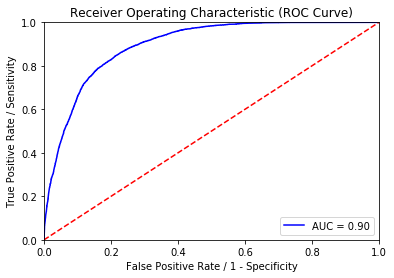

f1=0.517 auc=0.650 ap=0.650


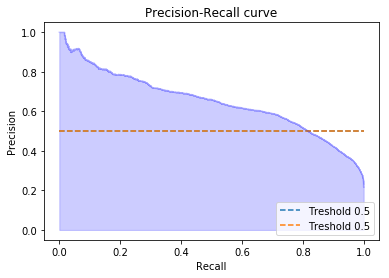

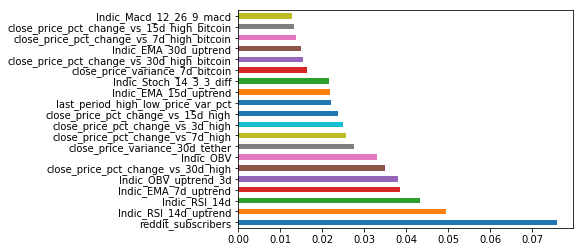

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[12810  3054]
 [  654  1273]]
[[TN, FP]
[FN, TP]]
Accuracy: 0.79


Other Metrics :

              precision    recall  f1-score   support

       False       0.95      0.81      0.87     15864
        True       0.29      0.66      0.41      1927

   micro avg       0.79      0.79      0.79     17791
   macro avg       0.62      0.73      0.64     17791
weighted avg       0.88      0.79      0.82     17791

----------------------------------------------------------



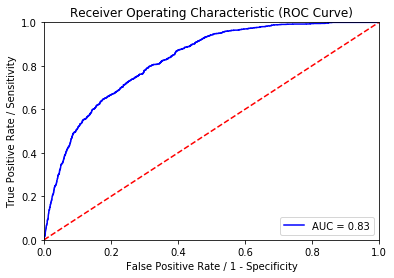

f1=0.407 auc=0.370 ap=0.370


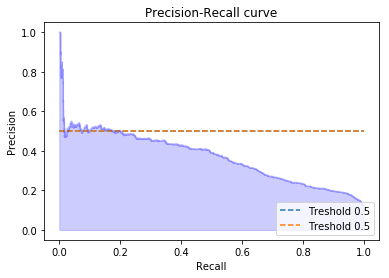

array([0.07286581, 0.07286581, 0.07946452, ..., 0.72433035, 0.72433035,
       0.72433035])


count     53371
unique        2
top       False
freq      43383
Name: y_+1d_classif, dtype: object

In [5]:
# -----------------------
# ALGO : RANDOM FOREST
# -----------------------

from sklearn.ensemble import RandomForestClassifier
#, n_estimators=100, max_features='auto', max_depth=5, criterion='entropy', class_weight="balanced"
# clf = RandomForestClassifier(random_state=0, class_weight="balanced", bootstrap=False,
#  criterion='entropy',
#  max_depth=5, #5
#  max_features='auto',
#  min_samples_leaf=4,
#  min_samples_split=10,
#  n_estimators=83).fit(X_train_scaled, y_train[y_to_be_considered])

clf = RandomForestClassifier(n_estimators=50, max_features='auto', max_depth=5, criterion='entropy', class_weight={0:1,1:7}, random_state = 0).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_precision_recall_curve=True, do_features_importance=True, threshold=threshold)
show_model_accuracy('RandomForestClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

# proba : to be shown by prediction, bien comprendre !
probas = clf.predict_proba(X_test_scaled)[:,1]
pprint(np.sort(probas))
y_test[y_to_be_considered].describe()
y_train[y_to_be_considered].describe()
#pprint(clf.get_params())

In [ ]:
# -----------------------
# ALGO : MLPClassifier - Neural Network (cf. Module+4 for tuning)
# -----------------------
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(hidden_layer_sizes = [130, 130], solver='lbfgs',
                     random_state = 0).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('MLPClassifier - Neural Network - Train', nnclf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('MLPClassifier - Neural Network - Test', nnclf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False, threshold=threshold)

# proba : to be shown by prediction, bien comprendre !
#print(pd.DataFrame(nnclf.predict_proba(X_test_scaled)[:,1]))

In [ ]:
# -----------------------
# ALGO : XGBOOST (cf. Module+4 for tuning)
# -----------------------
from xgboost import XGBClassifier

xgbc = XGBClassifier().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('XGBClassifier - Train', xgbc, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('XGBClassifier - Test', xgbc, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_precision_recall_curve=True, do_features_importance=True, threshold=threshold)

In [ ]:
show_model_accuracy('XGBClassifier - Train', xgbc, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('XGBClassifier - Test', xgbc, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_precision_recall_curve=True, do_features_importance=True, threshold=threshold)